# Rapid introduction to Deep Learning for Engineers

## Machine learning 

* learn a pattern from examples so that you as the programmer/modeler do not have to hand-tune the rules and relationships

* useful because these patterns can change with time, can be complex, or may require a lot of input features that are not friendly to human understanding/intuition (many variables or long histories, e.g. transaction or search histories, clickstreams, etc., versus easy to understand ...)

Examples
* identify fraudulent transaction
* predict customer churn
* recommend a likely next purchase based on previous purchases
* likely useful  webpage given query string
* likely relevant (high CTR) ad given query string and web history

Often predicting things in the future, but can also be simple identification or labeling, e.g. is that a photo of a cat or a dog. This notebook demonstrates the latter usecase.

Abstract: "supervised" machine learning uses examples consisting input features (transactions) and observed outcomes (next purchase) to create a function $f$ which maps an input $x \in \mathcal{X}$ to an outcome $y \in \mathcal{Y}$

$$
f: \mathcal{X} \rightarrow \mathcal{Y}
$$

It is "supervised" because you have the label/outcome $y$, the right answer. On the other hand, unsupervised machine learning contains a class of algorithms that do not rely on having the examples labeled, instead looking for patterns among the input features. E.g. clustering or "customer segmentation" that identifies customer groups that buys lots of veggies and no meat, another that prefers dairy+egg+prepackaged meals, etc.

The following examples will assume a binary outcome, e.g. Fraud/not fraud, chihauhua/muffin, hot dog/not a hot dog, but the approach will generalize to multiple outcomes or **classes** by modifying the very last layer.

## Linear classifiers

We start with a simple 2D example visualized below. There are two classes of points, orange and blue, that are described by two features (e.g. height and weight).

In [821]:
from __future__ import division, print_function

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [765]:
# Create some examples drawn from two 2D normal distributions
N = 50
mu = (2,3)
p1 = np.random.multivariate_normal((0,0), cov=[[1,0],[0,1]], size=N)
p2 = np.random.multivariate_normal(mu,    cov=[[1,0],[0,1]], size=N)

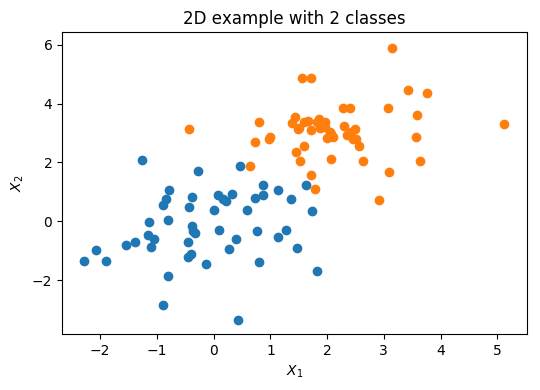

In [766]:
# Create input matrix where each row is an example (50 from each Gaussian distribution)
# and each column is a feature
X = np.vstack((p1,p2))

# Add bias term to input => this is like a line y=mx+b instead of just y=mx
X_b = np.hstack((np.ones((len(X),1)), X))

# Assign a "true label"
labels = np.asarray([0]*len(p1) + [1]*len(p2))

def plot_data():
    plt.scatter(p1[:,0], p1[:,1])
    plt.scatter(p2[:,0], p2[:,1])
    
plot_data()
plt.title('2D example with 2 classes')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$');

A linear classifier (e.g. logistic regression) seeks to find a line in 2D (or a hyperplane in multiple dimensions) that _best_ separates the two classes.

First, we have to define "best", and this is done mathematically with a _cost (or objective) function C_  that calculates a cost or penalty >0 for a wrong answer, which compares the true class $y$ to the prediction $h \in \mathcal{H}$ (for _hypothesis_):
$$
C: \{\mathcal{Y},\mathcal{H}\} \rightarrow \mathbb{R}_{\ge 0},
$$
where $\mathcal{H} = [0,1]$ is the set of real numbers between 0 and 1. In other words, the value of the prediction $h$ is interpreted as the predicted probability $\Pr(y=1|x)$ of the class label being 1 given the input features $x$.

(Neural network training is essentially an optimization problem, where the resulting learned model is the one with the lowest cost that the algorithm could find.)

We won't cover cost functions in detail, but as a helpful heursistic, imagine that orange points in the blue-dominated region have a cost $>0$ that increases linearly the further into the blue region it goes. On the other side, the orange-dominated region, the cost of an orange point is 0. In the middle near the decision boundary where the points mix, there is a small cost for a point close to the boundary even if it is on the correct "side". This last detail causes the algorithm to ignore far away correct points and to find a decision boundary with the best "safety margin" between opposite classes.

This is approximately the hinge loss used in Support Vector Machines (SVMs), also called maximum margin classifiers. In the example code, we use the log loss (the other popular choice) which is harder to understand conceptually, but yields probabilities at the network output. (Hinge loss results in non-probability "scores".)

In [767]:
def log_loss(predictions, labels, eps=1e-15):
    'Return the average log loss, where `eps` is a small value for numerical stability'
    labels = np.asarray(labels)
    predictions = np.clip(predictions, eps, 1-eps)
    return np.mean(-labels*np.log(predictions) - (1-labels)*np.log(1-predictions))

# Loss of perfect classifier (predictions = labels) should be zero
assert np.isclose(log_loss(labels, labels), 0)
# Loss of worst (all wrong) classifier should be -log(smallest_float)
assert np.isclose(-np.log(1e-15), log_loss(1-labels, labels), rtol=1e-4)

So you can imagine that a line that minimizes this cost will do the best to separate the two points into their respective regions. The learning algorithm finds the model parameters which minimize this cost on the training data.

The learning algorithm for our example is gradient descent. The model starts with a random set of parameters or weights $W$. Then, calculate the cost. Gradient descent then calculates a small amount to move each weight, which shifts the decision boundary, so that it lowers the cost by some small amount. It does this until the cost is approximately minimized, implying a best fit model to the data.

In summary:
1. Initialize model
2. Calculate update to reduce cost/error
3. Repeat until satisfied

For a much more in-depth explanation, see http://neuralnetworksanddeeplearning.com/.

**Step 1** is demonstrated below.

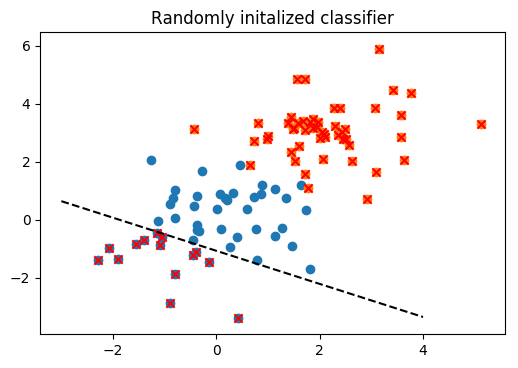

In [768]:
W = np.random.uniform(-1, 1, 3) # W[0] is a bias term

def logistic(z): return 1/(1 + np.exp(-z))

def predict(W, X):
    '''Return predicted probability P(Y=1|X) for every example in X
    
    Args:
        W (np.array):  A Px1 matrix of weights, where P is the number of input features +1 (for bias term)
        X (np.array):  A NxP matrix of input features with bias term 1 in first column
    '''
    return logistic(np.dot(X, W))

def plot_decision(W, X, Y):
    '''Plot decision boundary and misclassified examples

    Args:
        W (np.array):  A Px1 matrix of weights, where P is the number of input features +1 (for bias term)
        X (np.array):  A NxP matrix of input features with bias term 1 in first column
        Y (np.array):  A Nx1 matrix of class labels
        
    Returns:
        line and scatter plot objects
    '''
    # Create the separating line determined by the weights
    W_x = np.linspace(-3,4)
    W_y = -(W[0] + W[1]*W_x)/W[2]
    line, = plt.plot(W_x, W_y, 'k--')
    # Mark incorrect predictions with a red X
    p = predict(W, X)
    wrong = (p>.5) != Y
    _,x1,x2 = X[wrong].T
    incorrect = plt.scatter(x1, x2, marker='x', c='r')
    return line,incorrect

plot_data()
plot_decision(W, X_b, labels)
plt.title('Randomly initalized classifier');

**Step 2:** Calculate an update to the weights. 

The derivative of the cost function, `delta_log_loss`, determines how "wrong" each example is, and returns the delta used to calculate weight updates.

In [716]:
def delta_log_loss(predictions, labels):
    'Returns the N-dimensional derivative vector of the log loss wrt z, the argument to the logistic function'
    return -np.where(labels, 1/predictions, -1/(1-predictions)) * predictions * (1-predictions)

# TEST: All predictions = 0.3
deltas = delta_log_loss(np.zeros(len(labels))+.3, labels)

# If the label is 1, then "increasing" a prediction of 0.3 by a small amount 
# will *decrease* the cost, i.e. make it more correct by bringing the prediction closer to 1.
assert np.alltrue(np.where(labels, deltas<0, deltas>0))

The training step calculates the weight update $dW$ that reduces the cost and therefore improves the decision boundary. Note the `learning_rate` factor, here equal to 1 but typically a small number $<10^{-3}$, that causes the algorithm to take a much smaller step. This is important for more complicated models with many layers and parameters.

In [741]:
def train_step(W, X, Y, learning_rate=1):
    prediction = logistic(np.dot(X, W))
    delta_loss = delta_log_loss(prediction, Y)
    # Applying the derivative will increase the cost, so negate to decrease the cost
    dW = -learning_rate * np.dot(X.T, delta_loss) / len(X)
    return W + dW, dW

**Step 3:** Repeat until satisified.

Often, the training step is repeated until the change in some model performance measure is sufficiently small, i.e. the algorithm has stopped "learning". Alternatively, we train the model for a fixed number of steps, which bounds the amount of computation. We will see that both are used in practice in deep learning.

Large update in step 0: [-0.40665637  0.86314337  0.52542866]
Large update in step 3: [ 3.9299039   0.10439781  0.06238973]
Large update in step 4: [ 0.77644958  0.08452478  0.05198381]


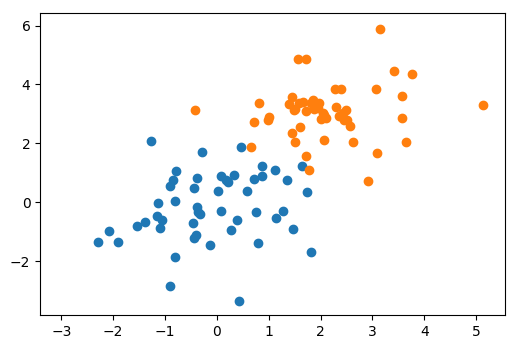

In [818]:
from matplotlib.animation import ArtistAnimation

W = np.random.uniform(-1, 1, 3)

figures = []

plot_data()

# Run gradient descent 100 times
for n in range(100):
    # Update the weights W.
    W,dW = train_step(W, X_b, labels)
    figures.append(plot_decision(W, X_b, labels))
    # It is also common practice in deep networks to check that the updates dW (called gradient checks)
    # are not too big or too small (cue Goldilocks joke). Not a concern here.
    if np.any((dW/W) > .5):
        # Deep learning prefers ~1-3% or so
        print("Large update in step %d: %s" % (n,dW/W))

anim = ArtistAnimation(plt.gcf(), figures, interval=50, blit=True)

In [819]:
# Animation of the learning algorithm
from IPython.display import display, HTML

src = anim.to_html5_video()
display(HTML(src))

There is a critical step 4 that we are skipping in this toy example: evaluating the resulting model on a fresh set of data. 

But what if the region is not _linearly separable_? For example, here we have one class surrounded by another. One cannot separate the examples using a straight line.

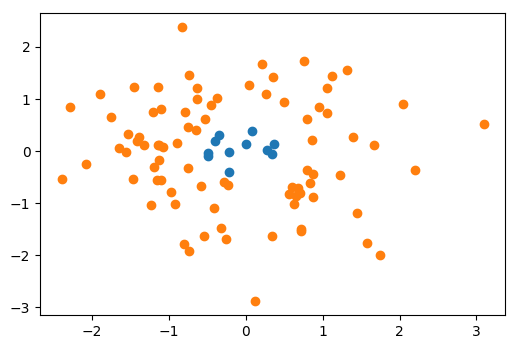

In [820]:
circle = np.random.multivariate_normal((0,0), [[1,0],[0,1]], 100)
r = np.sqrt((circle**2).sum(1))

c_ = circle[r<.5]
plt.scatter(c_[:,0], c_[:,1])

c_ = circle[r>.65]
plt.scatter(c_[:,0], c_[:,1]);

## Artificial neural networks

...are a kind of supervised ML algorithm (invented in the late 50s/60s) whose _name_ is inspired by the way neurons connect in the brain. But they have little to do with how brains do computation.

ANNs extend the simple linear classifier: Instead of just one separating line, there are multiple boundaries to combine, allowing the network to create complex decision boundaries for regions that are not _linearly separable_.

![single hidden layer network](images/Network331.png)

ANNs are typically visualized as a graph of connected nodes that does computation from left to right. The first _input layer_ nodes on the left are where the X values enter the computation graph. Equivalently, think of them as input vectors for a particular example.

Each input vector is passed to each "neuron" in the 2nd layer, where each node is actually a classifier by itself. Each one has its own separating boundary. These are combined together to form a single prediction in our binary output examples.

![3 layer](images/3-layer-NN.png)

The figure above was generated using a javascript library `convnet.js` that allows real-time ANN training in the browser. Andrej Karpathy teaches an excellent course on deep learning, and has [created a demo](http://cs.stanford.edu/people/karpathy/convnetjs/demo/classify2d.html) that uses this library. Paste in the code below and click "Change network".

```javascript
layer_defs = [];

// 2 dimensional input layer
layer_defs.push({type:'input', out_sx:1, out_sy:1, out_depth:2});

// 3 hidden neurons => 3 boundaries
layer_defs.push({type:'fc', num_neurons:3, activation: 'tanh'});
// combine them for 2-way classification
layer_defs.push({type:'softmax', num_classes:2});

net = new convnetjs.Net();
net.makeLayers(layer_defs);

trainer = new convnetjs.SGDTrainer(net, {learning_rate:0.01, momentum:0.1, batch_size:10, l2_decay:0.001});
```

## Muliple layer (deep) neural networks

**Deep learning** refers to a class of neural network architectures which have many layers with more sophisticated functions.

Starting with the single hidden layer network, add another hidden layer before the final output. You can think of the output of the first hidden layer as the _input_ to a downstream network, the 2nd hidden layer. Essentially, the first layer learns _features_ from the data which are used by downstream layers.

Here's an example of the first layer of a Convolutional ANN used for image recognition. These networks often learn edge patterns in the first layer.
![1st layer convnet from http://cs231n.github.io/understanding-cnn/](images/convnet.png)

Stack enough layers trained on enough data (e.g. 10M images from YouTube videos) and the downstream neurons (on the right of a network diagram) learn to recognize high-level features in the data, like faces (from [Le et al, 2012](https://arxiv.org/pdf/1112.6209.pdf))

![face neuron](images/face neuron.png)

These _higher-order features_ are learned high-level representations of the data. This hierarchical feature learning on large datasets powers the state-of-the-art performance of deep learning methods on many machine learning benchmarks.

In the same way that machine learning does not require a human to code the rules that relate the input features to the target outcome, deep learning does not require a human to _code the features either_. On the other hand, deep learning does require you to construct a good architecture, and train and tune it, which is still quite difficult.

So far, DL has found most success in tasks that are easy for humans to perform but hard to explain how we do it, like identifying images. 

## Creating an deep learning image classifier

Training a deep learning model from scratch can be difficult and expensive, although it is getting much easier and cheaper over time.

Fortunately, for this use case, you can leverage _pre-trained models_ that used millions of images to learn millions of model parameters. Recall that ANNs are composed of many layers. The last layers transform the many higher-level features (often many thousands) into a single prediction, in this case, a single scalar value. 

By finetuning an existing DL model by swapping out the last (fully connected) trained layers for new layers that you train on your particular dataset, you can often achieve extremely high accuracy with far less training data than the original model required.

Below, we demonstrate how to use the VGG16 pre-trained model to do exactly this. This model won the ImageNet competition in 2014, a well-known computer vision benchmark.

In this case, we will use the pre-trained model to identify an image as containing a cat or a dog. The ImageNet training set that the original model was trained on included many animal pictures, including cats and man's best friend, so we expect this model will do well with very little training data.

Images are from the Kaggle cats and dogs competition, available from [Microsoft](https://www.microsoft.com/en-us/download/details.aspx?id=54765). There are 25k images in the training set, but we will only use 1000 per class for training and 500 per class for testing.

In [ ]:
# Imports and constants

%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img
import keras.backend as K

K.set_image_data_format('channels_last')

# The desired image shape
img_width, img_height = 150, 150

TRAINING_DATA = 'data/train'
VAL_DATA = 'data/val'

`keras` is a deep learning library that is popular because of its ease of use. It comes with several pre-trained models, including VGG16. Fine-tuning is so common that there is a keyword `include_top` argument to shave off the last model layers for that purpose.

The model summary exposes the many model layers and parameters (or **weights** in ANN terms). **Can you confirm that all the model weights are fixed?**

In [4]:
# Get a copy of the model without the last layers
# and set the input image size. "3" is the number of color channels (RGB)
vgg = keras.applications.VGG16(
                               include_top=False,
                               input_shape=(img_width, img_height, 3),
                              )

# We do not want to re-train these layers
for layer in vgg.layers:
    layer.trainable = False

vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### Image processing and batching

One important caveat when using pre-trained models: *the input data must be in exactly the same form that the original model expected*. In this case, VGG16 input images were mean subtracted and the color channel order was reversed.

We use keras image processing and helper functions to create a stream of images from the dogs and cats directories.

Note the `batch_size` parameter. ANN learning algorithms do not process the entire training set at once, instead splitting it up into mini-batches (constrained by memory). A full run through all of the training data is called one _epoch_. Typically, many epochs of training are required to achieve good performance on large networks, but not so with our fine-tuned example.

In [5]:
import numpy as np

vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1,3))

def vgg_preprocess(x):
    """
        Subtracts the mean RGB value, and transposes RGB to BGR.
        The mean RGB was computed on the image set used to train the VGG model.
        Args: 
            x: Image array (height x width x channels)
        Returns:
            Image array (height x width x transposed_channels)
    """
    x = x - vgg_mean
    return x[:, :, ::-1] 

training = ImageDataGenerator(preprocessing_function=vgg_preprocess)

# This creates a python generator that yields (images,labels) tuples
train_gen = training.flow_from_directory(
    # subfolder in this path are classes, e.g. train/dogs & train/cats
    TRAINING_DATA,
    # the desired image size
    (img_width, img_height),
    # Training data is grouped into batches for training
    batch_size=16,
    # Use a 1/0 label because there are only 2 classes
    class_mode='binary',
    # Usually should shuffle, but not here to make it easier to inspect images
    shuffle=False
    )

Found 2000 images belonging to 2 classes.


In [6]:
# how to convert from the string label => class
train_gen.class_indices

{'cats': 0, 'dogs': 1}

Cat


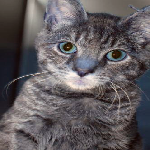

In [7]:
# Check an example. The generator returns an entire batch of 16.
# There are 1000 cats followed by 1000 dogs.
images,labels = next(train_gen)
label = 'Dog' if labels[0] else 'Cat'
print(label)
array_to_img(images[0])

In machine learning, do not evaluate your model on the same data that it was trained on. (Overfitting is a topic for another tutorial.) To get a more accurate estimate of the model's true performance, test it on a holdout.

In [8]:
# Create the validation set from another set of images

val_gen = training.flow_from_directory(
                             VAL_DATA,
                             (img_width, img_height),
                             batch_size=16,
                             class_mode='binary',
                             shuffle=True
                            )

Found 1000 images belonging to 2 classes.


In [9]:
images,labels = next(val_gen)

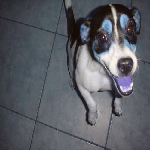

In [10]:
array_to_img(images[0])

## Build from the base

To limit training time on non-GPU machines, we will only train a single one last node at the end (after flattening the original model's output.) This effectively is logistic regression on the higher order features of the pre-trained model.

**What parts of this model will change during training?**

In [11]:
from keras.layers import Dense, Flatten
from keras.models import Model, Sequential

vgg_output = vgg.get_layer(index=-1).output

flat = Flatten()(vgg_output)
prediction = Dense(1, activation='sigmoid', name='logit')(flat)

model = Model(inputs=vgg.input, outputs=prediction)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

Optional: Add another layer called fc and see how the performance improves.

In [ ]:
# Try this! 

# from keras.layers import Dense, Flatten
# from keras.models import Model, Sequential

# vgg_output = vgg.get_layer(index=-1).output

# flat = Flatten()(vgg_output)
# fc = Dense(100, activation='relu', name='fc')(flat)
# prediction = Dense(1, activation='sigmoid', name='logit')(fc)

# model = Model(inputs=vgg.input, outputs=prediction)

# model.summary()

## Finetune

Finetuning correctly conveys the idea that only a small part of the model is changing. In the first step, the new model with a custom final layer is set up with an optimizer and loss function to minimize, in addition to specifying evaluation metrics.

An important aspect of fine-tuning is that the learning rate should be small so that only small changes are made to the weights. Of course, small is a relative concept, but $<10^{-3}$ is a good start. Generally, you will need to test several values across 2-3 orders of magnitude and choose the one that gives the best results.

To save time, the model is only fine-tuned for 1 epoch. More training generally yields better models with diminishing returns as it approaches an asymptote.

In [12]:
model.compile(optimizer=keras.optimizers.Adam(lr=.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.fit_generator(train_gen,
                    # The number of batches to count as 1 epoch
                    steps_per_epoch=train_gen.n / train_gen.batch_size,
                    epochs=1,
                    # The generator of validation images and labels
                    validation_data=val_gen,
                    # The number of validation batches (of 16) to run at the end of each training epoch
                    validation_steps=31,
                   )

After only 1 epoch of 2000 examples, the model already reaches ~90% accuracy!

### Validate images

Always a good idea to check the model outputs yourself.

In [ ]:
images,labels = next(val_gen)

predictions = model.predict_on_batch(images)

Correctly predicted Cat


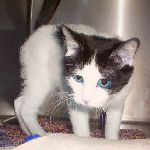

Correctly predicted Dog


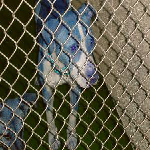

Correctly predicted Cat


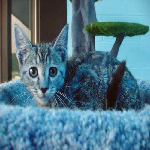

Correctly predicted Cat


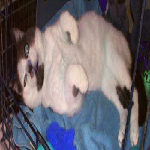

Correctly predicted Cat


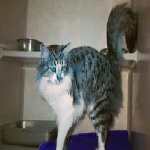

Correctly predicted Cat


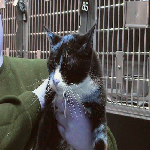

Correctly predicted Dog


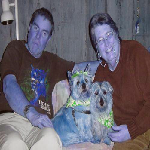

Correctly predicted Cat


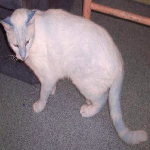

Correctly predicted Cat


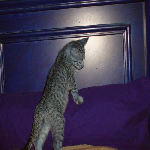

Correctly predicted Cat


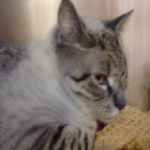

Correctly predicted Dog


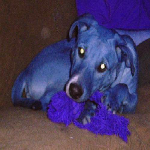

Correctly predicted Cat


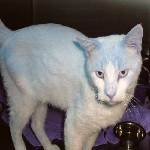

Correctly predicted Cat


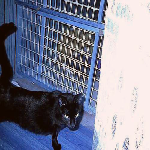

Correctly predicted Dog


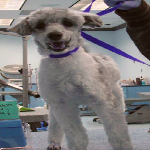

Correctly predicted Dog


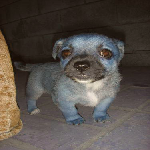

Correctly predicted Dog


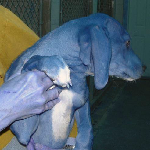

In [162]:
from IPython.display import display

for image,label,prediction in zip(images,labels,predictions):
    if (prediction>.5) == (label>.5):
        label = 'Dog' if label else 'Cat'
        print('Correctly predicted', label)
    else:
        print('INCORRECT')
    display(array_to_img(image))

## Engineering concerns

**Training time/cost >> evaluation time/cost**

**Evaluation time >> Java code**